# SailGP Data Analyst Challenge

The aim is to test you python abilities. The challenge is to analyze the data provided and answer the questions below. You can use any library you want to help you with the analysis. The data is from the SailGP event in Auckland 2025. The data is in the 'DATA' folder.

There are various sources available.

The Boat Logs are in the 'Boat_Logs' folder. The data is in csv format and the columns are described in the 'Boat_Logs/Boat_Logs_Columns.csv' file.
The 'Course_Marks_2025-01-19.csv' file contains the mark positions and wind reading on the course for the whole day.

The Race_XML folder contains the xml files for each race that contains information on where the boundaries of the course are, the theoretical position of the marks and the target racecourse axis.

The 2025-01-19_man_summary.csv file contains the metrics from the manoeuvre summary for the day.
The 2025-01-19_straight_lines.csv file contains the metrics from the straight line summary for the day.

Both are derived from the boat logs.

The 2502 m8_APW_HSB2_HSRW.kph.csv file contains the polar data for the boats in that config.

## Requierements
- Chose at least 3 questions from the list below to answer.
- Python 3.8 or higher
- Notebook should be able to run without any errors from start to finish.
- Specify the libraries (imports) used in the notebook.
- Any comments to make the notebook self-explanatory and easy to follow would be appreciated.
- If you can't get to the end of a question, we would appreciate the code you have written so far and explain what you were trying to do.

## Further information:
- We usually use bokeh for visualizations. So any showcase of bokeh would be appreciated.
-

## Submitting the results.
It would be great if you could provide a jupyter notebook with the code and the results of the analysis. You can submit the results by sharing a link to a git repository.


# Author: Elise Carlo 
February 2025

### Imports and re-used functions
Free section to initialize the notebook with the necessary imports and functions that will be used in the notebook.



In [108]:
#Imports listing
#----------------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import lxml
import subprocess
print(lxml.__version__)
from scipy.spatial.distance import euclidean
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
import math
from shapely.geometry import Polygon, Point, LineString
from shapely.geometry.polygon import orient
from geopy.distance import geodesic
from scipy.interpolate import interp1d
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score



output_notebook()

#----------------------------------------------------------------------------------------------------------------

#Basics functions listing
#----------------------------------------------------------------------------------------------------------------
#Function to convert .csv into Dataframe for futher analyse
def load_csv_to_df(file_path, delimiter=",", parse_dates=None):
    """
    Loads a CSV file into Pandas DataFrame.

    :param file_path: Path of the CSV file.
    :param delimiter: File delimiter (default "," but can be ";" or "\t" for other formats).
    :param parse_dates: List of columns to interpret as dates (eg: ["Timestamp"]).
    :return: DataFrame Pandas.
    """
    try:
        df = pd.read_csv(file_path, delimiter=delimiter, parse_dates=parse_dates)
        print(f"✅ File loaded : {file_path} ({df.shape[0]} lines, {df.shape[1]} columns)")
        return df
    except Exception as e:
        print(f"❌ Error loading {file_path} : {e}")
        return None

"""# Function test :
df = load_csv_to_df("Data/BOAT_Logs/data_AUS.csv", parse_dates=["TIME_LOCAL_unk"])
print(df.head())  # Afficher les 5 premières lignes"""
#----------------------------------------------------------------------------------------------------------------

#----------------------------------------------------------------------------------------------------------------
#Parsing xml race course files depending on the race number from the boat logs
def parse_course_xml(race_num, xml_dir="Data/Race_XMLs/"):
    """
    Selects and parses the XML file corresponding to the race number (race_num).
    Returns a race_course dictionary which associates a tuple (seq_id, lat, lon) with each CompoundMarkID.
    """
    # Search for the corresponding XML file by race number
    xml_file = None
    for filename in os.listdir(xml_dir):
        if filename.startswith(f"{race_num:08d}"): 
            xml_file = os.path.join(xml_dir, filename)
            break

    if xml_file is None:
        raise FileNotFoundError(f"No XML file found for race number {race_num}.")

    #print(f"Chargement du fichier XML : {xml_file}") 

    # Reading and parsing the XML file
    with open(xml_file, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "lxml-xml")
    
    race_course = {}

    # Extraction of marker information (waypoints)
    for compound_mark in soup.find_all("CompoundMark"):
        #print("Coumpound mark: ", compound_mark)
        compound_mark_name = compound_mark.get("Name")
        compound_mark_id = compound_mark.get("CompoundMarkID") 
        points = compound_mark.find_all("Mark")
        
        if len(points) > 1:  # Taking the mean point for the gates and lines to simplify
            latitudes = [float(mark.get("TargetLat")) for mark in points]
            longitudes = [float(mark.get("TargetLng")) for mark in points]
            #print("Lat:", latitudes, "lon: ", longitudes)
            avg_lat = np.mean(latitudes)
            avg_lon = np.mean(longitudes)
            #print("avg lat: ", avg_lat, "avg lon: ", avg_lon)
            marks = (compound_mark_name, avg_lat, avg_lon) 
        else:
            # If only one brand, take its position directly
            lat = float(points[0].get("TargetLat"))
            lon = float(points[0].get("TargetLng"))
            marks = (compound_mark_name, lat, lon)

        for corner in soup.find_all("Corner"):
            seq_id = int(corner.get("SeqID"))
            race_course[compound_mark_id] = (marks[0], marks[1], marks[2])

    return race_course, compound_mark_id

#-----------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------
# Function for calculating the distance between two points (Haversine formula)
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance (in km) between two points given in degrees.
    """
    # Earth's radius in km
    R = 6371  
    # Converting degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1)*math.cos(lat2)*math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    distance = R * c
    return distance


5.3.1


Loading BokehJS ...

## Streamilt visualisation interface

In [109]:
"""
In order to have a better visualisation of the data, I have made this quick visualisation dashboard, using streamlit.
It allows me to display the data in an interactive way and have a better understanding of the Boat_Logs files.
"""

subprocess.Popen(["streamlit", "run", "dashboard.py"])


<Popen: returncode: None args: ['streamlit', 'run', 'dashboard.py']>

## Question 1: Write a Python function that can take a compass direction (ie. TWD or Heading) and calculate an accurate mean value across a downsampled frequency. Eg. If TWD is at 1Hz, give me a 10s average.

In [110]:
def downsample_compass_direction(df, column="TWD", time_column="TIME_LOCAL_unk", window_size=10):
    """
    Calculates the average of a compass direction over a given time window.
    
    :param df: Boat_Logs DataFrame
    :param column: Name of the column containing the direction (eg: "TWD" or "Heading").
    :param time_column: Name of the time column (eg: "TIME_LOCAL_unk").
    :param window_size: Size of the averaging window (ex: 10s).
    :return: DataFrame with the average of the direction over each interval and the datetime
    """

    # Group data by windows of 'window_size' seconds
    df_resampled = df.set_index(time_column).resample(f"{window_size}S")
    
    # Apply vector average on each group
    def mean_compass_direction(angles):
        angles_rad = np.radians(angles.dropna())  # Convert to radians and ignore NaN
        mean_x = np.mean(np.cos(angles_rad))
        mean_y = np.mean(np.sin(angles_rad))
        mean_angle = np.degrees(np.arctan2(mean_y, mean_x))
        return mean_angle % 360  # Ensure that the angle remains between 0° and 360°

    df_downsampled = df_resampled[column].apply(mean_compass_direction).reset_index()
    return df_downsampled


"""#Function test
df = load_csv_to_df("Data/Boat_Logs/data_AUS.csv", parse_dates=["TIME_LOCAL_unk"])
downsample_df = downsample_compass_direction(df, column="HEADING_deg", window_size=10)
print(downsample_df)"""


'#Function test\ndf = load_csv_to_df("Data/Boat_Logs/data_AUS.csv", parse_dates=["TIME_LOCAL_unk"])\ndownsample_df = downsample_compass_direction(df, column="HEADING_deg", window_size=10)\nprint(downsample_df)'

## Question 2: Given a course XML and a timeseries of boat Lat/Lon values, calculate a VMC column for the same timeseries.


In [111]:

def calculate_vmc(df):
    """
    Calculates the VMC for each record in the dataframe, based on course marks and board number.
    :param df: Boat_Logs DataFrame
    :param xml files: takes the file corresponding to the race number. parse_course_xml() returns race_course, for the gates, start and finish lines it takes the middle point of the line
    :return: DataFrame with the VMC and a plot
    """
    def compute_vmc(row):
        race_num = int(row["TRK_RACE_NUM_unk"])
        leg_num = int(row["TRK_LEG_NUM_unk"])
        leg_tot = int(row["TRK_LEG_NUM_TOT_unk"])
        
        try:
            # parse_course_xml() returns the race_course dictionary 
            course_marks, compound_mark_id = parse_course_xml(race_num)
            
        except FileNotFoundError as e:
            print(e)
            return np.nan  # Returns NaN if XML file not found
        
        if leg_num > leg_tot:
            raise ValueError("TRK_LEG_NUM_unk cannot exceed TRK_LEG_NUM_TOT_unk.")
        
        # Checking edge sequence in XML
        if leg_num - 1 >= len(course_marks):
            raise IndexError(f"The requested {leg_num} edge does not exist in the XML file's edge sequence.")
        
        # Retrieve the mark corresponding to the current edge from race_course
        if compound_mark_id not in course_marks:
            raise KeyError(f"The compound_mark_id {compound_mark_id} was not found in race_course.")
            
        # Retrieve target mark based on 'leg_num + 1
        target_mark_id = str(leg_num + 1)  
        target_mark = course_marks.get(target_mark_id)
        #print("\nLeg num:", leg_num,"Target id:", target_mark_id,"target name: ", target_mark)

        if target_mark:  # If the mark exists
            mark_name, target_lat, target_lon = target_mark
            #print(f"Target:ID: {target_mark_id}, Name: {mark_name}, Latitude: {target_lat}, Longitude: {target_lon}")
        else:
            print(f"No mark found for ID {target_mark_id}. Checks edge sequence.")
            return 0 
        #print(f"Target:ID: {target_mark_id}, Name: {mark_name}, Latitude: {target_lat}, Longitude: {target_lon}")
        #print("Boat data: Lat:",row["LATITUDE_GPS_unk"], "Lon: ", row["LONGITUDE_GPS_unk"], "Speed: ", row["BOAT_SPEED_km_h_1"],"\n")
        # Calculation of the optimum direction to the mark
        # Conversion des latitudes et longitudes en radians
        lat1, lon1 = np.radians(row["LATITUDE_GPS_unk"]), np.radians(row["LONGITUDE_GPS_unk"])
        lat2, lon2 = np.radians(target_lat), np.radians(target_lon)

        # Différences de latitude et de longitude
        delta_lat = lat2 - lat1
        delta_lon = lon2 - lon1


        # Calcul du cap vers la cible
        x = np.sin(delta_lon) * np.cos(lat2)
        y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon)
        bearing_to_target = (np.degrees(np.arctan2(x, y)) + 360) % 360

        # Différence d'angle entre le cap actuel et la direction idéale
        angle_diff = np.radians(bearing_to_target - row["GPS_COG_deg"])

        # Calculation of VMC: projection of speed onto the ideal axis
        return row["GPS_SOG_km_h_1"] * np.cos(angle_diff), 

    # VMC calculation for each dataframe line
    df["VMC"] = df.apply(compute_vmc, axis=1)
    return df



def plot_vmc(df):
    """
    Generates a graph of CMV vs. time with Bokeh, displaying edge transitions.
    """    
    source = ColumnDataSource(df)
    p = figure(title="VMC vs Time", x_axis_label="Time", y_axis_label="VMC",
               x_axis_type="datetime", width=1300, height=500)
    
    # Tracer la VMC
    p.line("TIME_LOCAL_unk", "VMC", source=source, line_width=2, color="blue", legend_label="VMC")
    p.line("TIME_LOCAL_unk", "TRK_LEG_NUM_unk", source=source, line_width=2, color="black", legend_label="Leg Num")
    
    # Add markers for edge transitions
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta']  # Add more as needed
    for i, leg_num in enumerate(df["TRK_LEG_NUM_unk"].unique()):
        leg_data = df[df["TRK_LEG_NUM_unk"] == leg_num]
        color = colors[i % len(colors)]  # Cycle through colors if there are more legs than colors
        p.scatter(leg_data["TIME_LOCAL_unk"], leg_data["VMC"], size=4, color=color, legend_label=f"Leg {leg_num}")
  
    show(p)


# Running
df = pd.read_csv("Data/Boat_Logs/data_AUS.csv", parse_dates=["TIME_LOCAL_unk"])  # Load data
VMCadded_df = calculate_vmc(df)  # Calculate VMC for each dataframe line

plot_vmc(VMCadded_df) #Plot VMC graph
#print(VMCadded_df[["TIME_LOCAL_unk", "LATITUDE_GPS_unk", "LONGITUDE_GPS_unk", "GPS_SOG_km_h_1", "GPS_COG_deg", "VMC"]].head())  # Affichage



Overall the code allows compute the VMC. An improvement might be to try not to take the center point of lines or gates, because using the center point gives some wrong calculation during mark rounding even if it just for 3 to5 points. And as this is supposed to be post-processed data, so it's possible to know which mark the boat will take.

## Question 3: Verify and comment on the boats calibration. If possible propose a post-calibrated set of wind numbers and a potential calibration table.

Mean delta TWS 6.547076895227646 kph
Mean delta TWD -2.4709682019731365 °

Calibra table:
  ClosestMark  mean_delta_TWS  std_delta_TWS  mean_delta_TWD  std_delta_TWD  \
0         FL1        4.172901       2.367689      -11.256480      10.657522   
1         FL2        2.513125       2.180109       -2.836285       4.562231   
2         LG1        5.656052       4.139420       -8.880207       6.795637   
3         LG2        4.758570       4.129075       -1.274950       8.022267   
4          M1        8.277012       4.720475       -1.016756       5.716313   
5         SL1        4.803161       3.843590        2.476888       5.329757   
6         SL2        2.167638       4.788246       -5.168436       7.058163   
7         WG1       10.415589       3.985590       -0.579042       6.010949   
8         WG2        8.673613       5.828144       -2.213356       6.441410   

   count  
0     29  
1     64  
2    241  
3    558  
4    534  
5     34  
6     66  
7    191  
8    106  


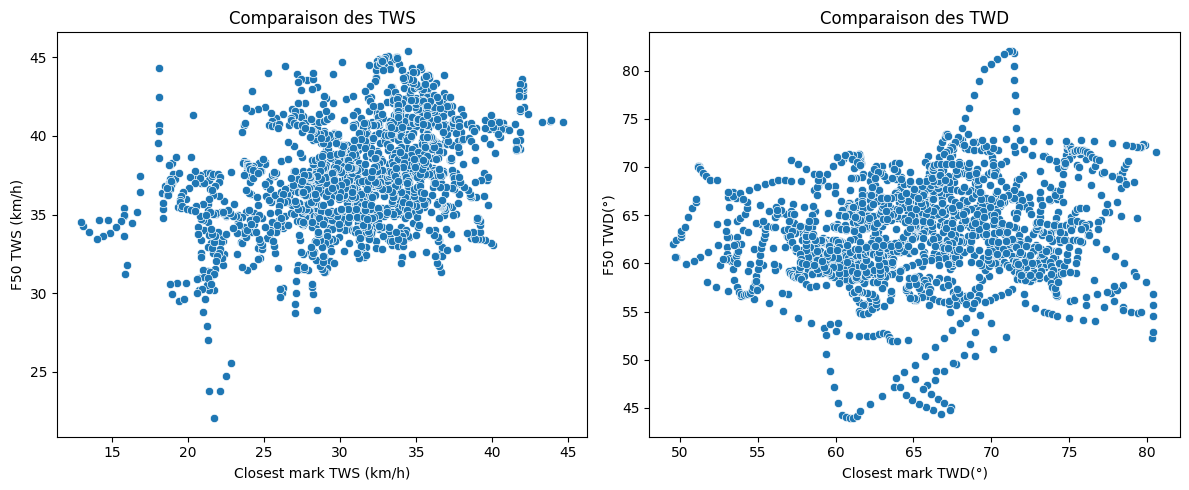

In [112]:

# Generic function for loading a CSV into a DataFrame with date conversion
def load_csv_to_df(path, parse_dates=None):
    return pd.read_csv(path, parse_dates=parse_dates)

# Search for the nearest brand using static coordinates
def find_closest_mark_static(boat_lat, boat_lon, marks_static):
    """
    Returns the name of the mark closest to the position (boat_lat, boat_lon) using the coordinates contained in marks_static.
    marks_static must be a DataFrame indexed by 'MARK' with 'LATITUDE_deg' and 'LONGITUDE_deg' columns.
    """
    #print("Mark static:\n", marks_static)
    min_distance = float("inf")
    #print("min dist:", min_distance)
    closest_mark_name = None
    for mark in marks_static.index:
        mark_lat = marks_static.loc[mark, 'LATITUDE_deg']
        mark_lon = marks_static.loc[mark, 'LONGITUDE_deg']
        distance = haversine_distance(boat_lat, boat_lon, mark_lat, mark_lon)*1000 #in meters
        #print(f"mark: {mark}, distance: {distance}, mark lon: {mark_lon}, mark lat{mark_lat}")
        #print(f"Boat lat {boat_lat}, boat lon {boat_lon}, min dist: {min_distance}")
        if distance < min_distance:
            min_distance = distance
            closest_mark_name = mark
        #print("Closest mark: ",closest_mark_name, "min dist: ",min_distance, "boat: lat:", boat_lat,"lon:", boat_lon, "mark: lat:",mark_lat, "lon:", mark_lon, "\n")
    return closest_mark_name, min_distance

# Recherche de la mesure la plus proche en temps pour une marque donnée
def get_nearest_mark_measurement(mark_name, boat_time, course_marks_df):
    """
    For a mark (mark_name) and a timestamp boat_time, selects the row in course_marks_df
    (filtered on 'MARK') whose timestamp (DATETIME column) is closest.
    
    Returns a Series containing the associated measurement, or None if no data is found.
    """
    #print("Mark name:",mark_name, "boat time:", boat_time,)
    df_mark = course_marks_df[course_marks_df['MARK'] == mark_name]
    if df_mark.empty:
        return None
    # Calcul de la différence absolue entre les timestamps
    time_diffs = (df_mark['DATETIME'] - boat_time).abs()
    nearest_idx = time_diffs.idxmin()
    return df_mark.loc[nearest_idx]

# Fonction principale de calibration des logs du bateau
def calibrate_boat_logs(boat_logs_df, course_marks_df):
    """
    For each boat log record, determines the nearest marker (based on GPS coordinates)
    and searches for the measurement on the marker closest in time.
        
        Then calculates:
    - Delta_TWS: difference between TWS measured on board (TWS_SGP_km_h_1) and on the mark (TWS_km_h_1)
    - Delta_TWD: difference between TWD measured on board (TWD_SGP_deg) and on the mark (TWD_deg)
    (brought back to the interval [-180, 180])
        
        Returns a DataFrame enriched with this information.
    """
    # Taking the mean position for each marks
    marks_static = course_marks_df.groupby('MARK').agg({
        'LATITUDE_deg': 'mean', 
        'LONGITUDE_deg': 'mean'
    }) # Using an iterrows by DATETIME would improve the precision
    
    results = []
    
    for idx, row in boat_logs_df.iterrows():
        boat_time = row['DATETIME']
        boat_lat = row['LATITUDE_GPS_unk']
        boat_lon = row['LONGITUDE_GPS_unk']
        
        # Looking for the closest mark
        closest_mark, mark_distance = find_closest_mark_static(boat_lat, boat_lon, marks_static)
        if closest_mark is None:
            continue
        
        # getting the wind measurement ofr the closest mark at the closest DATETME
        mark_measurement = get_nearest_mark_measurement(closest_mark, boat_time, course_marks_df)
        #print("mark measurement: ", mark_measurement)
        if mark_measurement is None:
            continue
        
        # Get wind measurements
        boat_TWS = row.get('TWS_SGP_km_h_1', np.nan)
        boat_TWD = row.get('TWD_SGP_deg', np.nan)
        mark_TWS = mark_measurement.get('TWS_km_h_1', np.nan)
        mark_TWD = mark_measurement.get('TWD_deg', np.nan)
        #print("boattws: ", boat_TWS, "boat twd: ", boat_TWD, "mark tws: ", mark_TWS, "mark twd: ", mark_TWD)
        
        # Offsets calculation
        delta_TWS = boat_TWS - mark_TWS if pd.notnull(boat_TWS) and pd.notnull(mark_TWS) else np.nan
        
        if pd.notnull(boat_TWD) and pd.notnull(mark_TWD):
            diff = boat_TWD - mark_TWD
            # Circulmar angles
            delta_TWD = (diff + 180) % 360 - 180
        else:
            delta_TWD = np.nan
        
        # Add datas to the df
        row_update = row.to_dict()
        row_update.update({
            'ClosestMark': closest_mark,
            'Mark distance': round(mark_distance,2),
            'Mark_DATETIME': mark_measurement['DATETIME'],
            'Mark_TWS': mark_TWS,
            'Mark_TWD': mark_TWD,
            'Delta_TWS': delta_TWS,
            'Delta_TWD': delta_TWD
        })
        results.append(row_update)
    
    calibrated_df = pd.DataFrame(results)
    return calibrated_df

# Optionnal generation of a table regrouping the deltas
def generate_calibration_table(calibrated_df):
    """
    Group deviations by brand to obtain calibration statistics:
    - Average and standard deviation of TWS and TWD deviations
    - Number of records per brand
    """
    calibration_table = calibrated_df.groupby('ClosestMark').agg(
        mean_delta_TWS=('Delta_TWS', 'mean'),
        std_delta_TWS=('Delta_TWS', 'std'),
        mean_delta_TWD=('Delta_TWD', 'mean'),
        std_delta_TWD=('Delta_TWD', 'std'),
        count=('Delta_TWS', 'count')
    ).reset_index()
    return calibration_table

# Plotting calibration results
def plot_calibration_results(calibrated_df):
    """
    Plots two scatter graphs to compare :
    -  TWS measured on-board vs TWS measured on-brand
    - TWD measured on-board vs TWD measured on-brand
    """
    plt.figure(figsize=(12, 5))

    # Comparaison de TWS
    plt.subplot(1, 2, 1)
    sns.scatterplot(x='Mark_TWS', y='TWS_SGP_km_h_1', data=calibrated_df)
    plt.xlabel('Closest mark TWS (km/h)')
    plt.ylabel('F50 TWS (km/h)')
    plt.title('Comparaison des TWS')
    
    # Comparaison de TWD
    plt.subplot(1, 2, 2)
    sns.scatterplot(x='Mark_TWD', y='TWD_SGP_deg', data=calibrated_df)
    plt.xlabel('Closest mark TWD(°)')
    plt.ylabel('F50 TWD(°)')
    plt.title('Comparaison des TWD')

    plt.tight_layout()
    plt.show()

# --- Main run ---
if __name__ == "__main__":
    # Loading files, datetime parsing
    course_marks_df = load_csv_to_df("Data/Course_Marks_2025-01-19.csv", parse_dates=["DATETIME"])
    boat_logs_df = load_csv_to_df("Data/Boat_Logs/data_AUS.csv", parse_dates=["DATETIME"])
    course_marks_df['DATETIME'] = course_marks_df['DATETIME'].dt.tz_localize(None)
    
    # Getting only the racing measuremenbts
    race_ids = boat_logs_df['TRK_RACE_NUM_unk'].unique()
    filtered_logs_list = []
    for race_id in race_ids:
        race_logs = boat_logs_df[
            (boat_logs_df['TRK_RACE_NUM_unk'] == race_id) & 
            (boat_logs_df['TRK_LEG_NUM_unk'] > 0) & 
            (boat_logs_df['TRK_LEG_NUM_unk'] <= boat_logs_df['TRK_LEG_NUM_TOT_unk'])
        ].copy()
        filtered_logs_list.append(race_logs)
    # Concatenate all races into a single DataFrame
    boat_logs_filtered = pd.concat(filtered_logs_list, ignore_index=True)
    #boat_logs_filtered.plot(x='LATITUDE_GPS_unk', y='LONGITUDE_GPS_unk')
    # Calibration
    calibrated_logs_df = calibrate_boat_logs(boat_logs_filtered, course_marks_df)
    print("Mean delta TWS", calibrated_logs_df['Delta_TWS'].mean(), "kph")
    print("Mean delta TWD", calibrated_logs_df['Delta_TWD'].mean(), "°")

    # Génération et affichage de la table de calibration
    calibration_table = generate_calibration_table(calibrated_logs_df)
    print("\nCalibra table:")
    print(calibration_table)
    
    # Visualisation graphique des comparaisons
    plot_calibration_results(calibrated_logs_df)


With this code, it is now possible to know the wind measurement delta between the boat and the marks for every instants, that can now be applied on the data for further analysis.

## Question 4: Given a timeseries of Lat/Lon positions and a course XML, in a Python notebook, calculate a Distance to Leader metric for each boat.

In [113]:


def load_csv_to_df(filepath, parse_dates=None):
    return pd.read_csv(filepath, parse_dates=parse_dates)

# 1. Logs concatenation by DATETIME
def load_boat_logs(boat_logs_dir="Data/Boat_logs"):
    all_logs = []
    for filename in os.listdir(boat_logs_dir):
        if filename.lower().endswith(".csv"):
            filepath = os.path.join(boat_logs_dir, filename)
            df_boat = load_csv_to_df(filepath, parse_dates=["DATETIME"])
            boat_id = os.path.splitext(filename)[0]
            df_boat["boat_id"] = boat_id
            all_logs.append(df_boat)
    boat_logs_df = pd.concat(all_logs, ignore_index=True)
    boat_logs_df["DATETIME"] = boat_logs_df["DATETIME"].dt.tz_localize(None)
    return boat_logs_df

# 2. Taking only the racing logs from crossing start line to finish line
def filter_logs(boat_logs_df):
    filtered_logs_list = []
    race_ids = boat_logs_df["TRK_RACE_NUM_unk"].unique()
    for race_id in race_ids:
        race_logs = boat_logs_df[
            (boat_logs_df["TRK_RACE_NUM_unk"] == race_id) &
            (boat_logs_df["TRK_LEG_NUM_unk"] > 0) &
            (boat_logs_df["TRK_LEG_NUM_unk"] <= boat_logs_df["TRK_LEG_NUM_TOT_unk"])
        ].copy()
        filtered_logs_list.append(race_logs)
    filtered_logs_df = pd.concat(filtered_logs_list, ignore_index=True)
    return filtered_logs_df 

# 3. Reading and parsing the races XMLs
def parse_course_xml_ordered(race_num, xml_dir="Data/Race_XMLs/"):
    """
    Searches xml_dir for the file whose name begins with the race number (before the first '_') and 
    returns an ordered list of marks as tuples (name, latitude, longitude).
    """
    xml_file = None
    race_str = str(race_num)
    for filename in os.listdir(xml_dir):
        # File has to be written like "raceNum_xx-xx-xx.xml"
        if filename.split("_")[0] == race_str:
            xml_file = os.path.join(xml_dir, filename)
            print("Fichier XML trouvé :", filename)
            break
    if xml_file is None:
        raise FileNotFoundError(f"Aucun fichier XML trouvé pour le numéro de course {race_num}.")
    
    with open(xml_file, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "lxml-xml")
    
    course_marks = []
    for compound_mark in soup.find_all("CompoundMark"):
        mark_name = compound_mark.get("Name")
        points = compound_mark.find_all("Mark")
        if len(points) > 1:
            latitudes = [float(mark.get("TargetLat")) for mark in points]
            longitudes = [float(mark.get("TargetLng")) for mark in points]
            avg_lat = np.mean(latitudes)
            avg_lon = np.mean(longitudes)
            mark = (mark_name, avg_lat, avg_lon)
        else:
            lat = float(points[0].get("TargetLat"))
            lon = float(points[0].get("TargetLng"))
            mark = (mark_name, lat, lon)
        course_marks.append(mark)
    return course_marks


# 4. Progress and dist calculation

# Distance in between 2 marks
def compute_leg_distance(mark_A, mark_B):
    return geodesic((mark_A[1], mark_A[2]), (mark_B[1], mark_B[2])).meters

# Linear progression of the boat during a leg
def project_point_on_line(start, end, point):
    """
    start, end: tuples (name, lat, lon) for leg segment, start = previous mark ,end = next mark
    point: tuple (lat, lon) for boat position
    Returns the distance (in meters) from start to the point projected on the segment.
    """
    R = 6371000  # Earth curve
    latA, lonA = np.radians(start[1]), np.radians(start[2])
    latB, lonB = np.radians(end[1]), np.radians(end[2])
    latP, lonP = np.radians(point[0]), np.radians(point[1])
    # Approximate conversion to local coordinates (equirectangular method)
    xA = R * lonA * np.cos(latA)
    yA = R * latA
    xB = R * lonB * np.cos(latA)
    yB = R * latB
    xP = R * lonP * np.cos(latA)
    yP = R * latP
    AB = np.array([xB - xA, yB - yA])
    AP = np.array([xP - xA, yP - yA])
    t = np.dot(AP, AB) / np.dot(AB, AB)
    t = np.clip(t, 0, 1)
    proj_distance = np.linalg.norm(t * AB)
    return proj_distance

# Progression on the race course
def compute_boat_progress(boat_df, course_marks):
    progress = []
    for _, row in boat_df.iterrows():
        leg = int(row["TRK_LEG_NUM_unk"])
        if leg <= 0:
            progress.append(0)
        else:
            # Adding in the passed legs linear distance in the total leg
            total = 0
            for i in range(leg):
                total += compute_leg_distance(course_marks[i], course_marks[i+1])
            
            # For an unfinished leg, we add the distance between the last mark and the boat         
            start_mark = course_marks[leg-1]
            next_mark = course_marks[leg] if leg < len(course_marks) else course_marks[-1]
            partial = project_point_on_line(start_mark, next_mark, (row["LATITUDE_GPS_unk"], row["LONGITUDE_GPS_unk"]))
            #print(f"start mark: {start_mark} next mark: {next_mark} boat lat: {row['LATITUDE_GPS_unk']} lon: {row['LONGITUDE_GPS_unk']}")
            #print(f"partial: {partial}, total: {total}")
            progress.append(total + partial)
    boat_df["course_progress"] = progress
    return boat_df

# Dist to leader calculation
def compute_distance_to_leader(filtered_logs_df, course_marks):
    boat_ids = filtered_logs_df["boat_id"].unique()
    list_boat_dfs = []
    for boat in boat_ids:
        df_boat = filtered_logs_df[filtered_logs_df["boat_id"] == boat].sort_values("DATETIME")
        df_boat = compute_boat_progress(df_boat, course_marks)
        list_boat_dfs.append(df_boat)
        #print("liste boat df: ", list_boat_dfs)
    df_progress = pd.concat(list_boat_dfs, ignore_index=True)
    #print("")
    df_progress["distance_to_leader"] = np.nan
    for timestamp, group in df_progress.groupby("DATETIME"):
        leader_progress = group["course_progress"].max()
        df_progress.loc[group.index, "distance_to_leader"] = leader_progress - group["course_progress"]
    return df_progress


if __name__ == "__main__":
    # 1. Boat logs loading
    boat_logs_df = load_boat_logs("Data/Boat_logs")
    # 2. "In race" boat logs filtering
    filtered_logs_df = filter_logs(boat_logs_df)
    
    # 3. Current race XML file selection
    race_num = int(filtered_logs_df["TRK_RACE_NUM_unk"].iloc[0])
    #print("race num: ", race_num)
    # 4. Reading and parsing the corresponding XML file
    course_marks = parse_course_xml_ordered(race_num, xml_dir="Data/Race_XMLs/")
    
    # 5. Dist to leader calculation
    logs_with_metrics = compute_distance_to_leader(filtered_logs_df, course_marks)
    
    logs_with_metrics = logs_with_metrics.sort_values(by="DATETIME")
    
    print(logs_with_metrics.head())
    output_notebook()

    # Plot
    p = figure(title="Évolution de la Distance to Leader", 
            x_axis_label="Temps", 
            y_axis_label="Distance au Leader (m)", 
            x_axis_type="datetime", 
            width = 1200,
            height = 600
            )
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan'] #One color per boat for a better visualisation
    for i, (boat_id, df_boat) in enumerate(logs_with_metrics.groupby("boat_id")):
        df_boat = df_boat.sort_values("DATETIME")
        p.line(x=df_boat["DATETIME"], 
            y=df_boat["distance_to_leader"],  
            line_width=2, 
            color=colors[i % len(colors)], 
            legend_label=str(boat_id))

    p.legend.location = "top_right"
    p.legend.click_policy = "hide"

    show(p)

Fichier XML trouvé : 25011905_03-13-55.xml
      BOAT            DATETIME       TIME_LOCAL_unk  LATITUDE_GPS_unk  \
0      AUS 2025-01-19 03:08:01  2025-01-19 16:08:01        -36.833091   
1      AUS 2025-01-19 03:08:02  2025-01-19 16:08:02        -36.832907   
13036  NZL 2025-01-19 03:08:02  2025-01-19 16:08:02        -36.833541   
2      AUS 2025-01-19 03:08:03  2025-01-19 16:08:03        -36.832718   
3557   DEN 2025-01-19 03:08:03  2025-01-19 16:08:03        -36.833524   

       LONGITUDE_GPS_unk  BOAT_SPEED_km_h_1  GPS_SOG_km_h_1  HEADING_deg  \
0             174.768475              79.78           76.61       344.23   
1             174.768394              78.79           78.79       343.47   
13036         174.767258              36.29           36.06         2.11   
2             174.768343              76.44           74.03       348.51   
3557          174.766966              69.56           69.08       337.64   

       TWA_SGP_deg  TWS_SGP_km_h_1  ...  TRK_RACE_NUM_unk  PC

Loading BokehJS ...

Overall the code gives us a not so bad distance to leader when I compare it the SailGP Data Insight. But I think an improvement that could be tried would be to change the calculation progress, the linear calculation progress is not the real boat progress. With a better achievement of the question 5, I would be able to calculate the progress not on a linear projection but on a theorical trajojectory. For post-processing data analysis, I think that using the actuel tracjectory of each boats could also be tried.
Those 2 methods could improve the calculation, on wich boat is the real leader and limit the impact of mark best approching edge right after the mark rounding.
But to be sure those needs to be tried and compare with my current result.

## Question 5: Given a course XML, along with a wind speed and direction and a polar, calculate the minimum number of tacks or gybes for each leg of the course and each gate mark on the leg.

In [114]:
def deg2rad(deg):
    return deg * math.pi / 180

def rad2deg(rad):
    return rad * 180 / math.pi

def compute_bearing(lat1, lon1, lat2, lon2):
    """
    Calculates the bearing (in degrees) of the segment from point (lat1, lon1) to (lat2, lon2)
    """
    lat1, lon1, lat2, lon2 = map(deg2rad, [lat1, lon1, lat2, lon2])
    dLon = lon2 - lon1
    x = math.sin(dLon) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dLon)
    initial_bearing = math.atan2(x, y)
    initial_bearing = rad2deg(initial_bearing)
    return (initial_bearing + 360) % 360

def angle_difference(angle1, angle2):
    diff = abs(angle1 - angle2) % 360
    if diff > 180:
        diff = 360 - diff
    return diff

# --- Man calc ---

def calculate_min_maneuvers(start_coord, end_coord, wind_dir, polar):
    """
    Calculates the minimum number of turns required to cover the segment from start_coord to end_coord.
    
    -  start_coord and end_coord are tuples (lat, lon)
    - wind_dir is wind direction in degrees
    - polar is a dictionary containing, for example: 'upwind_optimum': minimum upwind angle (ex: 45°) 'downwind_optimum': optimum angle downwind (e.g. 150°)
    The logic is simplified:
    - If the angle between course and wind is upwind (relative_angle < 90°), and this angle is less than the optimum angle, it is assumed that a maneuver is necessary.
    - The same applies downwind (relative_angle ≥ 90°).
    """
    bearing = compute_bearing(start_coord[0], start_coord[1],
                              end_coord[0], end_coord[1])
    relative_angle = angle_difference(bearing, wind_dir)
    
    if relative_angle < 90:
        optimum = polar.get('upwind_optimum', 45)
        maneuvers = 0 if relative_angle >= optimum else 1
    else:
        optimum = polar.get('downwind_optimum', 150)
        maneuvers = 0 if relative_angle <= optimum else 1
        
    return maneuvers

def calculate_min_maneuvers_gate(start_coord, gate_coord, wind_dir, polar):
    """
    Minimal man calc
    """
    bearing = compute_bearing(start_coord[0], start_coord[1],
                              gate_coord[0], gate_coord[1])
    relative_angle = angle_difference(bearing, wind_dir)
    
    if relative_angle < 90:
        optimum = polar.get('upwind_optimum', 45)
        maneuvers = 0 if relative_angle >= optimum else 1
    else:
        optimum = polar.get('downwind_optimum', 150)
        maneuvers = 0 if relative_angle <= optimum else 1
        
    return maneuvers

def main():
    # Race and wind parameters
    race_num = 25011905  # Race num
    xml_dir = "Data/Race_XMLs/"
    wind_dir = 67       # TWD
    wind_speed = 36     # TWS
    polar = {
        'upwind_optimum': 45,
        'downwind_optimum': 150
    }
    
    # Parsing XML
    try:
        race_course, _ = parse_course_xml(race_num, xml_dir)
    except Exception as e:
        print("Erreur lors du parsing du XML :", e)
        return
    
    if not race_course:
        print("Aucun marqueur trouvé dans le fichier XML.")
        return
    
    print("Race marks :")
    for cmp_id, (name, lat, lon) in race_course.items():
        print(f"  CompoundMarkID: {cmp_id}, Name: {name}, Lat: {lat}, Lon: {lon}")
    

    try:
        sorted_markers = sorted(race_course.items(), key=lambda x: int(x[0]))
    except ValueError:
        sorted_markers = sorted(race_course.items(), key=lambda x: x[0])
    
    # Man calc for each legs
    for i in range(len(sorted_markers) - 1):
        id_start, marker_start = sorted_markers[i]
        id_end, marker_end = sorted_markers[i + 1]
        start_coord = (marker_start[1], marker_start[2])
        end_coord = (marker_end[1], marker_end[2])
        
        maneuvers_leg = calculate_min_maneuvers(start_coord, end_coord, wind_dir, polar)
        print(f"  Leg '{marker_start[0]}' (ID {id_start}) to '{marker_end[0]}' (ID {id_end}) : {maneuvers_leg} maneuver(s)")
        

        if "Gate" in marker_end[0] or "Gate" in marker_end[0]:
            maneuvers_gate = calculate_min_maneuvers_gate(start_coord, end_coord, wind_dir, polar)
            print(f"    -> For gate '{marker_end[0]}' : {maneuvers_gate} maneuver")

if __name__ == "__main__":
    main()


Race marks :
  CompoundMarkID: 1, Name: SL1, Lat: -36.834987, Lon: 174.7686595
  CompoundMarkID: 2, Name: M1, Lat: -36.829713, Lon: 174.76527
  CompoundMarkID: 3, Name: LG1, Lat: -36.8338455, Lon: 174.7548255
  CompoundMarkID: 4, Name: WG1, Lat: -36.829794, Lon: 174.767608
  CompoundMarkID: 5, Name: LG1, Lat: -36.8338455, Lon: 174.7548255
  CompoundMarkID: 6, Name: WG1, Lat: -36.829794, Lon: 174.767608
  CompoundMarkID: 7, Name: LG1, Lat: -36.834715, Lon: 174.755873
  CompoundMarkID: 8, Name: FL1, Lat: -36.8358705, Lon: 174.75856149999998
  Leg 'SL1' (ID 1) to 'M1' (ID 2) : 0 maneuver(s)
  Leg 'M1' (ID 2) to 'LG1' (ID 3) : 1 maneuver(s)
  Leg 'LG1' (ID 3) to 'WG1' (ID 4) : 1 maneuver(s)
  Leg 'WG1' (ID 4) to 'LG1' (ID 5) : 1 maneuver(s)
  Leg 'LG1' (ID 5) to 'WG1' (ID 6) : 1 maneuver(s)
  Leg 'WG1' (ID 6) to 'LG1' (ID 7) : 1 maneuver(s)
  Leg 'LG1' (ID 7) to 'FL1' (ID 8) : 0 maneuver(s)


As it is for now, the code is able to calculate the number of maneuvers per legs for a given race course, but this is a simplified version, to be more accurate those changes would be needed: 
    -using the gates and not a middle point
    -adding the boundaries
    -using the boat polar and not static polar
    -using the mark wind measurement ant not a mean static value

To improve, I have tried this new code: 

Gybing required
Tacking required
Gybing required
Tacking required
Gybing required
Computed optimal path: [(-36.8348995, 174.768891), (-36.829713, 174.76527), (-36.830252579534964, 174.76474064845544), (-36.83328673143498, 174.7551356341918), (-36.83026257953408, 174.76749664838658), (-36.83328673143498, 174.7551356341918), (-36.83026257953408, 174.76749664838658), (-36.835849499999995, 174.758567)]
Total needed tacks:  2
Total needed gybes:  3


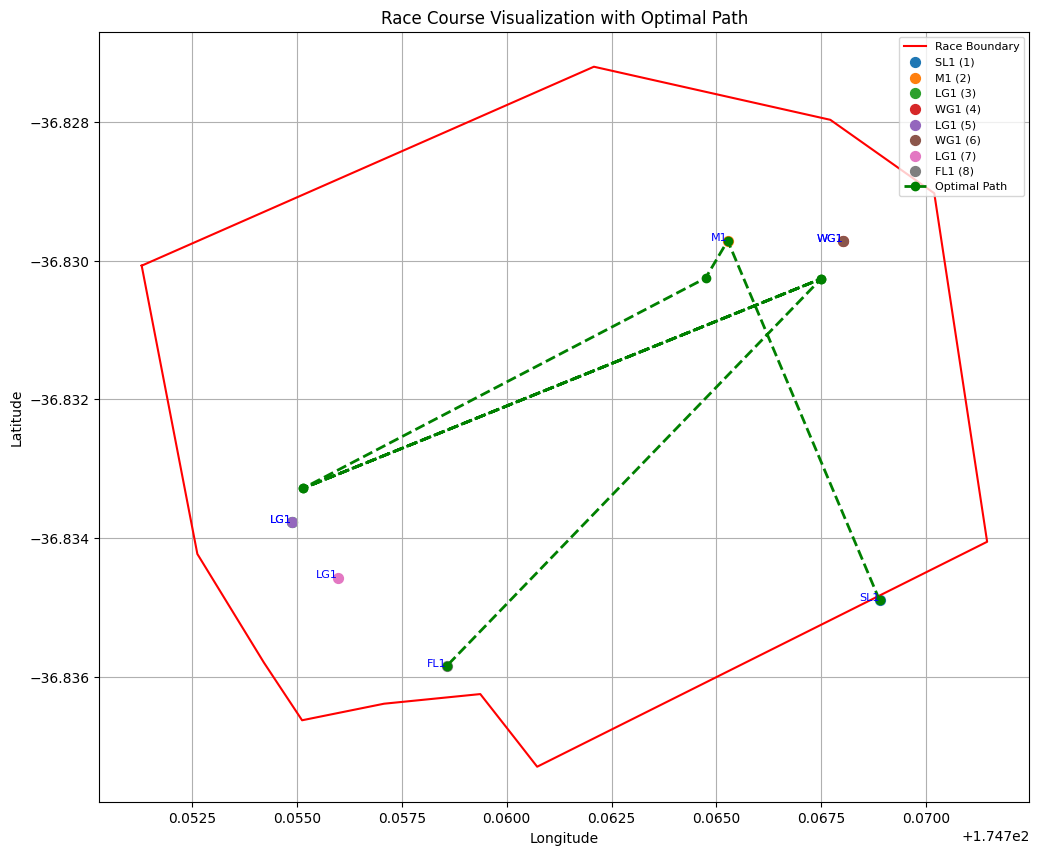

In [115]:
# ----------------------------------------------------------------------------------------------------------------
# Function to parse XML race course and boundaries
def parse_course_xml(race_num, xml_dir="Data/Race_XMLs/"):
    """
    Parses the XML course file for a given race number and extracts both the race course and boundaries.

    :param race_num: Race number to find the corresponding XML file.
    :param xml_dir: Directory containing the XML files.
    :return: Tuple (race_course, boundaries).
             - race_course: Dictionary of CompoundMarkID -> (Name, Lat, Lon).
             - boundaries: Shapely Polygon object representing the race boundaries.
    """
    # Search for the XML file matching the race number
    xml_file = None
    for filename in os.listdir(xml_dir):
        if filename.startswith(f"{race_num:08d}"):
            xml_file = os.path.join(xml_dir, filename)
            break

    if xml_file is None:
        raise FileNotFoundError(f"No XML file found for race number {race_num}.")

    # Parse the XML file
    with open(xml_file, "r", encoding="utf-8") as file:
        soup = BeautifulSoup(file, "lxml-xml")

    # Extract race course
    race_course = {}
    for compound_mark in soup.find_all("CompoundMark"):
        compound_mark_name = compound_mark.get("Name")
        compound_mark_id = compound_mark.get("CompoundMarkID")
        points = compound_mark.find_all("Mark")

        if len(points) > 1:  # If it's a gate with multiple points
            latitudes = [float(mark.get("TargetLat")) for mark in points]
            longitudes = [float(mark.get("TargetLng")) for mark in points]
            avg_lat = np.mean(latitudes)
            avg_lon = np.mean(longitudes)
            marks = (compound_mark_name, avg_lat, avg_lon)
        else:  # If it's a single mark
            lat = float(points[0].get("TargetLat"))
            lon = float(points[0].get("TargetLng"))
            marks = (compound_mark_name, lat, lon)

        race_course[compound_mark_id] = (marks[0], marks[1], marks[2])

    # Extract boundaries
    boundary_coords = []
    course_limit = soup.find("CourseLimit", {"name": "Boundary"})
    if course_limit:
        for limit in course_limit.find_all("Limit"):
            lat_str = limit.get("Lat")
            lon_str = limit.get("Lon")
            if lat_str is not None and lon_str is not None:
                lat = float(lat_str)
                lon = float(lon_str)
                boundary_coords.append((lon, lat))
            else:
                print(f"⚠️ Attribut manquant dans <Limit>: {limit}")

    boundaries = Polygon(boundary_coords)

    return race_course, boundaries
# ----------------------------------------------------------------------------------------------------------------
# Visualization function for race course
def plot_boundaries_and_race_course(race_course, boundary_coords, optimal_path):
    """
    Visualizes race boundaries, course marks, and optimal sailing path.
    :param race_course: Dictionary of CompoundMarkID -> (Name, Lat, Lon)
    :param boundary_coords: List of (lon, lat) tuples for boundaries
    :param optimal_path: List of waypoints for optimal path
    """
    # Create and validate boundary polygon
    polygon = Polygon(boundary_coords)
    if not polygon.is_valid:
        print("⚠️ Invalid boundary polygon. Applying buffer fix...")
        polygon = polygon.buffer(0)
    polygon = orient(polygon, sign=1.0)  # Ensure CCW orientation

    # Plot setup
    plt.figure(figsize=(12, 10))
    x, y = polygon.exterior.xy
    plt.plot(x, y, color='red', label='Race Boundary')

    # Plot course marks
    for compound_mark_id, (name, lat, lon) in race_course.items():
        plt.scatter(lon, lat, label=f"{name} ({compound_mark_id})", s=50)
        plt.text(lon, lat, name, fontsize=8, ha='right', color='blue')

    # Plot optimal path
    if optimal_path:
        path_x, path_y = zip(*optimal_path)
        plt.plot(path_y, path_x, linestyle="--", color="green", linewidth=2, marker="o", label="Optimal Path")

    # Chart configuration
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Race Course Visualization with Optimal Path")
    plt.legend(loc='upper right', fontsize=8)
    plt.grid()
    plt.show()


# ----------------------------------------------------------------------------------------------------------------
# Heading calculation between marks
def calculate_headings(race_course):
    """
    Calculates headings between consecutive marks in a race course.
    :param race_course: Dictionary of mark coordinates
    :return: List of headings between consecutive marks in degrees
    """
    headings = []
    mark_ids = list(race_course.keys())
    
    for i in range(len(mark_ids) - 1):
        start_mark = race_course[mark_ids[i]]
        end_mark = race_course[mark_ids[i+1]]

        # Convert to radians
        lat1 = math.radians(start_mark[1])
        lon1 = math.radians(start_mark[2])
        lat2 = math.radians(end_mark[1])
        lon2 = math.radians(end_mark[2])

        # Calculate bearing
        delta_lon = lon2 - lon1
        x = math.sin(delta_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(delta_lon)
        
        bearing_rad = math.atan2(x, y)
        bearing_deg = (math.degrees(bearing_rad) + 360) % 360
        
        headings.append(bearing_deg)

    return headings


# ----------------------------------------------------------------------------------------------------------------
# Optimal path calculation
def calculate_optimal_path(race_course, boundaries, wind_df, polar_data, upwind_angle=45, downwind_angle=150):
    """
    Calculates optimal sailing path considering wind conditions and boat polar data.

    :param race_course: Dictionary of mark coordinates
    :param boundaries: Shapely Polygon of race boundaries
    :param wind_df: DataFrame with wind data (TWD and TWS)
    :param polar_data: Polar data dictionary {TWA: {TWS: Speed}}
    :param upwind_angle: Upwind sailing limit angle (degrees)
    :param downwind_angle: Downwind sailing limit angle (degrees)
    :return: List of optimal path waypoints
    """
    # Calculate average wind conditions
    TWD = wind_df['TWD_deg'].mean()
    TWS = wind_df['TWS_km_h_1'].mean()
    tacks = 0
    gybes = 0
    waypoints = []
    previous_point = None

    for compound_mark_id, (_, lat, lon) in race_course.items():
        current_point = Point(lon, lat)

        # Validate mark position
        if not boundaries.contains(current_point):
            print(f"Warning: Mark {compound_mark_id} is outside boundaries.")

        # Initial point handling
        if previous_point is None:
            waypoints.append((lat, lon))
            previous_point = current_point
            continue

        # Calculate course heading
        lat1, lon1 = previous_point.y, previous_point.x
        lat2, lon2 = lat, lon
        delta_lon = math.radians(lon2 - lon1)
        lat1_rad = math.radians(lat1)
        lat2_rad = math.radians(lat2)

        x = math.sin(delta_lon) * math.cos(lat2_rad)
        y = math.cos(lat1_rad) * math.sin(lat2_rad) - math.sin(lat1_rad) * math.cos(lat2_rad) * math.cos(delta_lon)
        course_heading = (math.degrees(math.atan2(x, y)) + 360) % 360

        # Calculate true wind angle
        twa = abs((course_heading - TWD + 360) % 360)
        twa = 360 - twa if twa > 180 else twa

        # Path strategy selection
        if twa < upwind_angle:
            print("Tacking required")
            tacks += 1
            waypoints += calculate_tack_segments(previous_point, current_point, TWD, upwind_angle, polar_data, TWS)
        elif twa > downwind_angle:
            print("Gybing required")
            gybes += 1
            waypoints += calculate_gybe_segments(previous_point, current_point, TWD, downwind_angle, polar_data, TWS)
        else:
            waypoints.append((lat, lon))

        previous_point = current_point

    return waypoints, tacks, gybes


# Helper functions for path calculation
def calculate_tack_segments(start, end, TWD, upwind_angle, polar_data, TWS):
    """Calculates optimal tacking path segments."""
    waypoints = []
    current_point = start
    
    while True:
        # Alternate tacks
        tack_heading = (TWD - upwind_angle + 360) % 360
        next_point = project_point(current_point, tack_heading, polar_data, TWS, TWD)

        if is_point_closer(next_point, end, current_point):
            waypoints.append((next_point.y, next_point.x))
            break
        else:
            waypoints.append((next_point.y, next_point.x))
            upwind_angle = -upwind_angle
            current_point = next_point

    return waypoints


def calculate_gybe_segments(start, end, TWD, downwind_angle, polar_data, TWS):
    """Calculates optimal gybing path segments."""
    waypoints = []
    current_point = start
    
    while True:
        # Alternate gybes
        gybe_heading = (TWD + downwind_angle) % 360
        next_point = project_point(current_point, gybe_heading, polar_data, TWS, TWD)

        if is_point_closer(next_point, end, current_point):
            waypoints.append((next_point.y, next_point.x))
            break
        else:
            waypoints.append((next_point.y, next_point.x))
            downwind_angle = -downwind_angle
            current_point = next_point

    return waypoints


def haversine_projection(latitude, longitude, heading, distance):
    """Projects a point using Haversine formula."""
    destination = geodesic(kilometers=distance/1000).destination((latitude, longitude), heading)
    return destination.latitude, destination.longitude


def project_point(start_point, heading, polar_data, TWS, TWD):
    """Projects a point based on sailing conditions."""
    # Calculate boat speed from polar data
    twa = abs((heading - TWD + 360) % 360)
    twa = 360 - twa if twa > 180 else twa
    speed = get_polar_speed(twa, TWS, polar_data)

    # Calculate projection
    dt = 1  # Time step in hours
    distance = speed * dt
    new_lat, new_lon = haversine_projection(start_point.y, start_point.x, heading, distance)
    
    return Point(new_lon, new_lat)


def is_point_closer(next_point, target_point, current_point):
    """Checks if next point is closer to target than current position."""
    return next_point.distance(target_point) < current_point.distance(target_point)


# ----------------------------------------------------------------------------------------------------------------
# Polar data handling
def load_polar_data_from_table(polar_csv_path):
    """
    Loads and formats polar data from CSV file.
    
    :param polar_csv_path: Path to polar data CSV file
    :return: Dictionary {TWA: {TWS: Speed}}
    """
    try:
        polar_df = pd.read_csv(polar_csv_path, index_col=0)
        return {
            float(twa): {
                float(tws): float(speed)
                for tws, speed in row.items()
            }
            for twa, row in polar_df.iterrows()
        }
    except Exception as e:
        print(f"Error loading polar data: {e}")
        return None


def get_polar_speed(twa, tws, polar_data):
    """Interpolates boat speed from polar data with error handling."""
    try:
        # Convert keys to sorted arrays
        twa_values = np.array(sorted(polar_data.keys()))
        tws_values = np.array(sorted({tws for data in polar_data.values() for tws in data.keys()}))
        
        # Find nearest indices
        twa_idx = np.abs(twa_values - twa).argmin()
        tws_idx = np.abs(tws_values - tws).argmin()
        
        return polar_data[twa_values[twa_idx]][tws_values[tws_idx]]
    except Exception as e:
        print(f"Polar interpolation error: {e}")
        return 0.0


# ----------------------------------------------------------------------------------------------------------------
# Main execution
if __name__ == "__main__":
    # Configuration parameters
    RACE_NUMBER = 25011906
    XML_DIR = "Data/Race_XMLs/"
    POLAR_PATH = "Data/2502 m8_APW_HSB2_HSRW.kph.csv"

    # Data loading
    course, boundaries = parse_course_xml(RACE_NUMBER, XML_DIR)
    wind_data = pd.read_csv("Data/Course_Marks_2025-01-19.csv")
    polar_data = load_polar_data_from_table(POLAR_PATH)

    # Path calculation
    optimal_path, tacks, gybes = calculate_optimal_path(course, boundaries, wind_data, polar_data)
    print("Computed optimal path:", optimal_path)
    print("Total needed tacks: ",tacks)
    print("Total needed gybes: ", gybes)

    # Visualization
    boundary_coords = list(boundaries.exterior.coords)
    plot_boundaries_and_race_course(course, boundary_coords, optimal_path)

With this code, I have tried to go further ine the calculation process adding the boundaries, the boat polars and the wind measurement on the marks to try and calculate an optimal path to be as efficient as possible. But looking at the graph, it is obviously not optimal yet and the optimal is not coherent with the reality and what is possible to do, but it still gives a coherent tacks an gybes number. 

## Question 6: Calculate a “tacked” set of variables depending on the tack of the boat, so that sailors don’t need to think about what tack they’re on when looking at measurements. And show the results in a visualisation.


In [116]:
path = r'Data\Boat_Logs\data_NZL.csv'

data = pd.read_csv(path)
#print(data.columns)

In [117]:
#Looking for the race numbers
race_id = data.TRK_RACE_NUM_unk.unique()
print(race_id)


[25011905. 25011906. 25011907.]


In [118]:
race_data = data[data["TRK_RACE_NUM_unk"] == 25011905]  #Selection d'une course
race_data = race_data[(race_data["TRK_LEG_NUM_unk"] > 0) & (race_data["TRK_LEG_NUM_unk"] <= race_data["TRK_LEG_NUM_TOT_unk"])].reset_index(drop=True)  #Ne pas prendre en compte la phase de départ
#print(race_data)

In [119]:
path = r'Data\Boat_Logs\data_AUS.csv'

data = pd.read_csv(path)
#print(data.columns)
#Looking for the race numbers
race_id = data.TRK_RACE_NUM_unk.unique()
#print(race_id)
race_data = data[data["TRK_RACE_NUM_unk"] == 25011905]  #Selection d'une course
race_data = race_data[(race_data["TRK_LEG_NUM_unk"] > 0) & (race_data["TRK_LEG_NUM_unk"] <= race_data["TRK_LEG_NUM_TOT_unk"])].reset_index(drop=True)  #Ne pas prendre en compte la phase de départ
#print(race_data)
#race_data.plot(x='LONGITUDE_GPS_unk', y='LATITUDE_GPS_unk')


Tacked variables calculated.


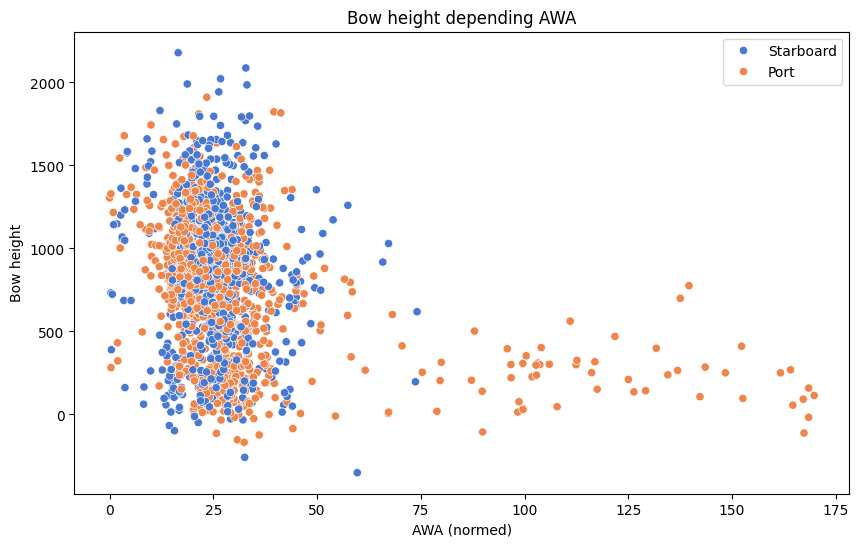

In [120]:
"""
-Creation of new variable named Tack that equals Starboard or Port depending on the AWA sign
-Creation of new absolute vars
"""

def calculate_tacked_variables(df):
    df["Tack"] = np.where(df["AWA_SGP_deg"] > 0, "Starboard", "Port")
    
    # Exemples of new "tacked" vars
    df["AWA_Tacked"] = df["AWA_SGP_deg"].abs()
    df["TWA_Tacked"] = df["TWA_SGP_deg"].abs()
    print("Tacked variables calculated.")
    return df

def visualize_tacked_data(df):

    # Exemples of new "tacked" vars plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="AWA_Tacked", y="LENGTH_RH_BOW_mm", hue="Tack", data=df, palette="muted")
    plt.title("Bow height depending AWA")
    plt.xlabel("AWA (normed)")
    plt.ylabel("Bow height")
    plt.legend()
    plt.show()

# Loading boat logs
#boat_logs_df = load_csv_to_df("Data/Boat_Logs/data_AUS.csv", parse_dates=["TIME_LOCAL_unk"])
boat_logs_df = pd.read_csv("Data/Boat_Logs/data_AUS.csv")

if boat_logs_df is not None:
    tacked_df = calculate_tacked_variables(boat_logs_df)
    
    visualize_tacked_data(tacked_df)

This code allows to create a new var named 'Tack' that either equals Port of Starboard depending on the AWA sign. That can be used in numerous cases, like the small graph I did to compare the bow height on each sides. I  have also added that var to my streamlit visualisation interface, so when replaying the race, the tack can be broadcast.

## Question 7: Given a set of tacks (in CSV), and train a model to explain the key features of these tacks when optimizing for vmg. Show appropriate visualisations to explain your conclusions.

In [121]:
# Function to extract tack and gybe data
def tack_gybes_df_extract():
    path = r'Data\2025-01-19_man_summary.csv'
    data = pd.read_csv(path)
    #print("Data: ", data.head())
    race_id = data.race.unique()
    #print(race_id)
    tack_data = data[data["type"] == 'tack'] 
    gybe_data = data[data["type"] == 'gybe']
    #race_data = race_data[(race_data["TRK_LEG_NUM_unk"] > 0) & (race_data["TRK_LEG_NUM_unk"] <= race_data["TRK_LEG_NUM_TOT_unk"])].reset_index(drop=True)  #Ne pas prendre en compte la phase de départ
    #print(tack_data)
    return tack_data, gybe_data

tack_data, gybe_data = tack_gybes_df_extract()
print("Tacks: ",tack_data.columns)
#print("Gybes: ", gybe_data.head())

Tacks:  Index(['BOAT', 'HULL', 'WING_CONFIG_unk', 'MD4_SEL_DB_unk', 'MD4_SEL_RUD_unk',
       'DATETIME', 'TIME_LOCAL_unk', 'race', 'leg', 'type',
       ...
       'loss_vs_targ_vmg', 'drop_offset', 'drop_to_wind_axis', 'htw_bsp',
       'entry_cant', 'exit_cant', 'cant_drop_target', 'cant_stow_target',
       'dashboard', 'entry_tack'],
      dtype='object', length=109)


Index(['entry_bsp', 'exit_bsp', 'min_bsp', 'bsp_loss', 'entry_twa', 'exit_twa',
       'entry_rh', 'exit_rh', 'entry_rh_stability', 'max_yaw_rate', 'db_down',
       'two_DB_time', 'two_DB_Broadcast', 'flying', 'tws', 'pop_time',
       'turn_min_rh', 't_invert', 't_to_lock', 'max_lat_gforce',
       'max_fwd_gforce', 'max_gforce', 'drop_time_P', 'drop_time_S',
       'unstow_time_P', 'unstow_time_S', 'stow_time_P', 'stow_time_S',
       'boards_up_time_S', 'boards_up_time_P', 'entry_heel', 'entry_pitch',
       'exit_heel', 'exit_pitch', 'turning_time', 't_swap', 'bsp_at_drop',
       'heel_at_drop', 'pitch_at_drop', 'winward_rh_at_drop', 'entry_jib_lead',
       'exit_jib_lead', 'entry_jib_sheet', 'exit_jib_sheet',
       'entry_jib_sheet_pct', 'exit_jib_sheet_pct', 'max_rudder_angle',
       'vmg_distance', 'avg_TWD', 'distance', 'bearing', 'bearing_2',
       'drop_offset', 'drop_to_wind_axis', 'htw_bsp', 'entry_cant',
       'exit_cant', 'cant_drop_target', 'cant_stow_target'],
  

C:\Users\Elise\AppData\Local\Temp\ipykernel_7372\4291531106.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vmg_corr.index, y=vmg_corr.values, palette="coolwarm")


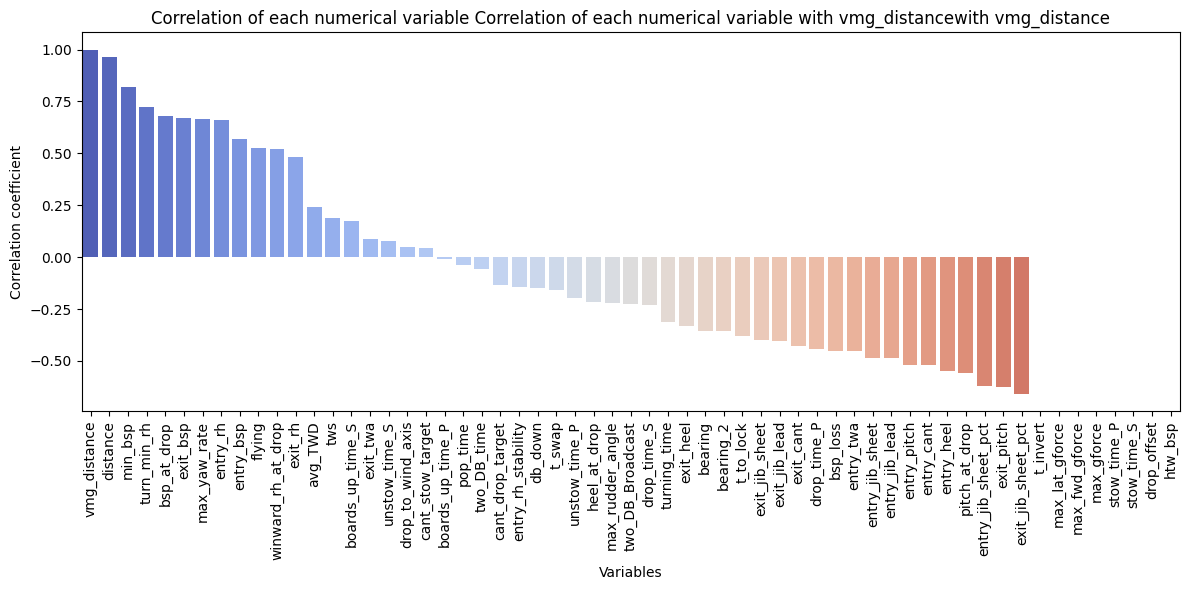

Optimal mean values of variables for a good vmg_distance :
 entry_bsp                58.995000
exit_bsp                 55.664000
min_bsp                  40.494000
bsp_loss                 18.501000
entry_twa                45.195000
exit_twa                 53.610000
entry_rh                992.855000
exit_rh                 886.120000
entry_rh_stability     1918.005000
max_yaw_rate             31.041500
db_down                   5.470000
two_DB_time               7.620000
two_DB_Broadcast         10.960000
flying                    0.800000
tws                      39.150000
pop_time                  0.730000
turn_min_rh             559.850000
t_invert                       NaN
t_to_lock                 1.980000
max_lat_gforce            0.000000
max_fwd_gforce            0.000000
max_gforce                0.000000
drop_time_P               2.806667
drop_time_S               2.390000
unstow_time_P             0.130000
unstow_time_S             0.325000
stow_time_P               0.00

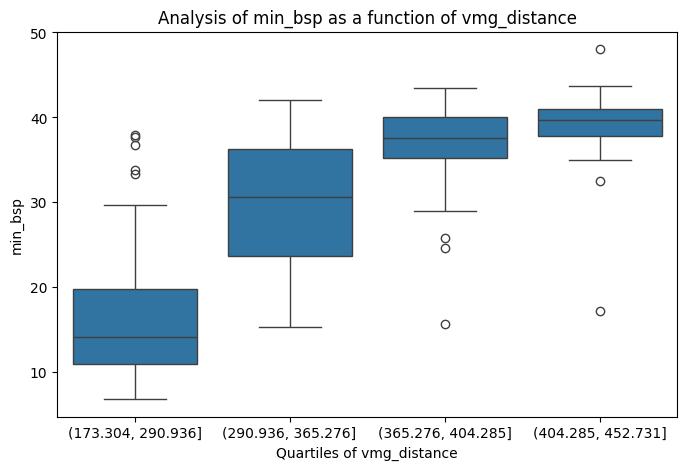

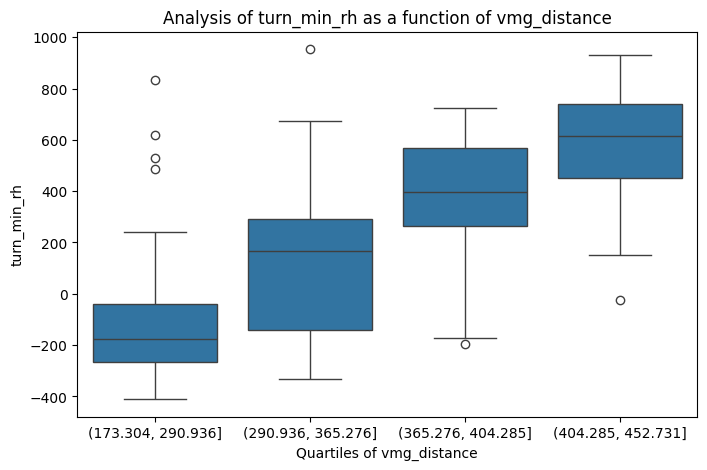

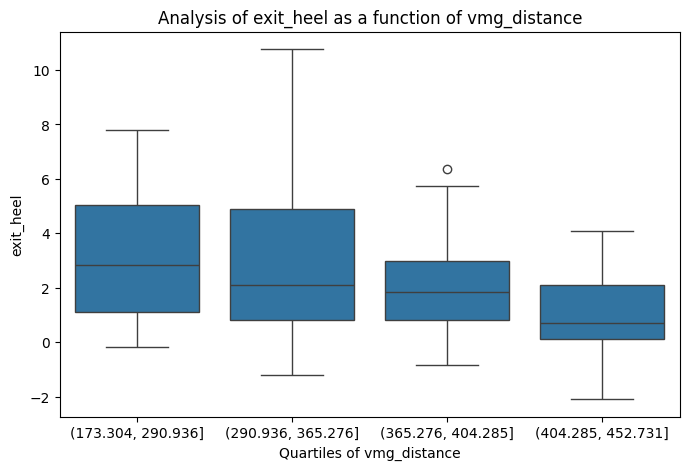

Key variables according to Random Forest :
 min_bsp                0.580365
bsp_at_drop            0.080328
exit_twa               0.047317
entry_twa              0.029795
t_swap                 0.023860
exit_cant              0.021676
exit_bsp               0.019956
exit_jib_sheet_pct     0.018298
entry_jib_sheet_pct    0.016484
entry_bsp              0.012346
bearing_2              0.012021
flying                 0.010002
bearing                0.010002
exit_pitch             0.009542
entry_jib_sheet        0.008228
entry_heel             0.007586
turning_time           0.007336
exit_rh                0.006990
bsp_loss               0.006648
entry_jib_lead         0.006551
avg_TWD                0.005743
entry_cant             0.005436
two_DB_Broadcast       0.005150
pitch_at_drop          0.005060
db_down                0.004545
drop_to_wind_axis      0.004467
exit_heel              0.004198
max_yaw_rate           0.003975
entry_pitch            0.003786
tws                    0.003

C:\Users\Elise\AppData\Local\Temp\ipykernel_7372\4291531106.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.index, y=importances.values, palette="coolwarm")


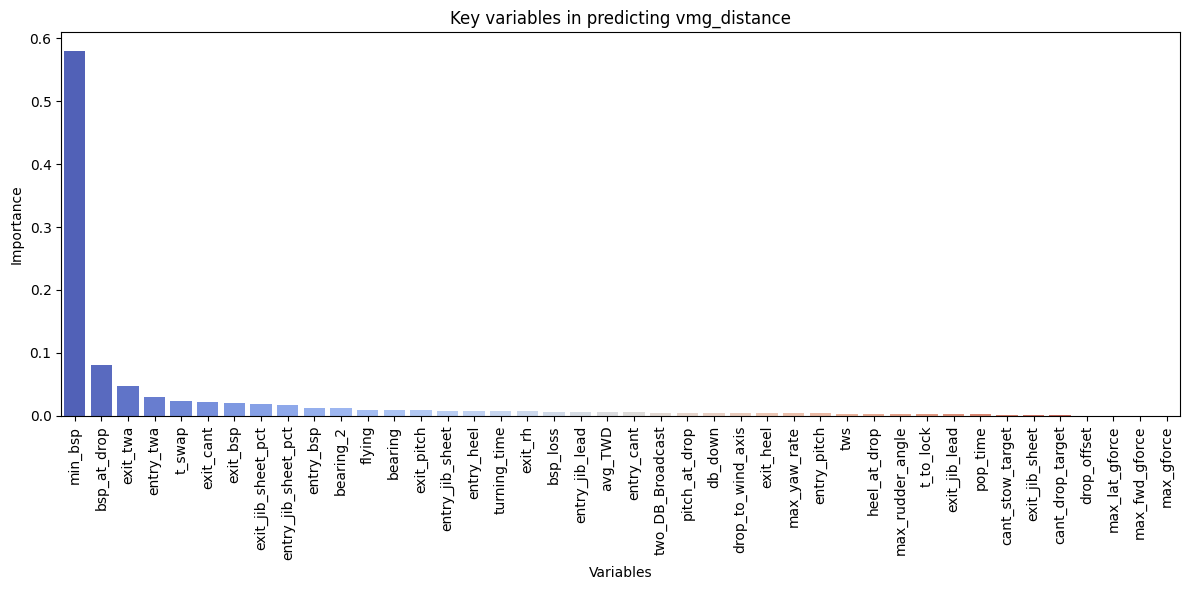

In [122]:
# Only select numeric columns
numeric_df = tack_data.select_dtypes(include=[np.number])

# Dorpping the columns that I do not understand for now without a column description
columns_to_drop = ['WING_CONFIG_unk', 'MD4_SEL_DB_unk', 'MD4_SEL_RUD_unk', 'race', 'leg', 'orig_entry_twa', 'orig_exit_twa',
                   'press_sys_acc_start', 'press_sys_acc_end', 'press_sys_acc_delta', 
                   'press_rake_acc_start', 'press_rake_acc_end', 'press_rake_acc_delta', 
                   'pump_press_avg', 'pump_press_max', 'press_wing_acc_start', 
                   'press_wing_acc_end', 'db_ud_ret_press_s_avg', 'db_ud_ret_press_s_max', 
                   'db_ud_ret_press_p_avg', 'db_ud_ret_press_p_max', 'db_ud_ext_press_s_avg', 
                   'db_ud_ext_press_s_max', 'db_ud_ext_press_p_avg', 'db_ud_ext_press_p_max',  
                   'db_cant_ret_press_p_avg', 'db_cant_ret_press_p_max', 'db_cant_ret_press_s_avg', 
                   'db_cant_ret_press_s_max', 'db_cant_ext_press_p_avg', 'db_cant_ext_press_p_max', 
                   'db_cant_ext_press_s_avg', 'db_cant_ext_press_s_max', 'b_diff', 'b_diff_1', 
                   'b_diff_2', 'dist_2', 'theoretical_vmg', 'theoretical_target_vmg', 
                   'theoretical_distance', 'theoretical_targ_distance', 'loss_vs_vmg', 
                   'loss_vs_targ_vmg']



numeric_df = numeric_df.drop(columns_to_drop, axis=1)
print(numeric_df.columns)

# Correletion matrix
corr_matrix = numeric_df.corr()

# 2. Correlation with vmg_distance, can be changed
vmg_corr = corr_matrix["vmg_distance"].sort_values(ascending=False)
print("Corrélations avec vmg_distance :\n", vmg_corr)

# 3. Correlation plot
plt.figure(figsize=(12,6))
sns.barplot(x=vmg_corr.index, y=vmg_corr.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Correlation of each numerical variable Correlation of each numerical variable with vmg_distancewith vmg_distance")
plt.xlabel("Variables")
plt.ylabel("Correlation coefficient")
plt.tight_layout()
plt.show()

# 4. Analyze optimal variable values for a good vmg_distance

# Set a threshold for the top 10% of vmg_distance values
top_vmg_threshold = numeric_df['vmg_distance'].quantile(0.9)

# Separate the data into two groups: top 10% and the rest
top_vmg = numeric_df[numeric_df['vmg_distance'] >= top_vmg_threshold]

# Calculate the mean and median of the variables for the top 10%
optimal_values = top_vmg.mean()  # ou .median()
print("Optimal mean values of variables for a good vmg_distance :\n", optimal_values)

# 5. Visualization of key variables (e.g. min_bsp, turn_min_rh)
key_vars = ["min_bsp", "turn_min_rh", "exit_heel"]  # Can be changed

for var in key_vars:
    plt.figure(figsize=(8,5))
    sns.boxplot(x=pd.qcut(numeric_df['vmg_distance'], q=4), y=numeric_df[var])
    plt.xlabel("Quartiles of vmg_distance")
    plt.ylabel(var)
    plt.title(f"Analysis of {var} as a function of vmg_distance")
    plt.show()

# 6. Modeling with Random Forest to identify determining variables
X = numeric_df.drop(columns=['vmg_distance', 'distance'])
y = numeric_df['vmg_distance']

X = X.dropna(axis='columns')
y = y.loc[X.index] 

# Training the model
model = RandomForestRegressor()
model.fit(X, y)

# Key variables
importances = pd.Series(model.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)
print("Key variables according to Random Forest :\n", importances)

# Key vars plotting
plt.figure(figsize=(12,6))
sns.barplot(x=importances.index, y=importances.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Key variables in predicting vmg_distance")
plt.xlabel("Variables")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


As I did not have a complete colomns description and did not undrestood the meaning of every vars yet, I chose to use only the vars that I understood.
The conclusions are based on the fact tat the "vmg_distance" is accurate.
As it could be expected the 3 most important vars that have influence on the vmg_distance are: the min_bsp, the bspt_at_drop, wich is a lot related to min_bsp, and the exit_twa. Regarding the F50s racing those 3 were heavily expected to have a big influence on the tack performance.

In [123]:
# Calculation of the Euclidean distance between each line and the optimal values
diff = numeric_df - optimal_values  
numeric_df['distance_to_optimal'] = np.sqrt((diff**2).sum(axis=1))

# Select the 10 tack whose distance from optimal_values is minimum
top10_tacks = numeric_df.sort_values('distance_to_optimal').head(10)

print("Top 10 tack (closest to optimum values):")
print(top10_tacks)


Top 10 tack (closest to optimum values):
     entry_bsp  exit_bsp  min_bsp  bsp_loss  entry_twa  exit_twa  entry_rh  \
232      48.58     51.69    35.20     13.38       40.4      49.1     883.5   
269      55.81     49.28    38.30     17.51       39.7      65.5     998.1   
194      50.43     64.19    38.35     12.08       32.5      63.3     776.7   
196      53.99     57.86    40.20     13.79       40.6      45.8     978.4   
235      59.62     51.78    40.63     18.99       45.3      46.2    1210.2   
229      58.94     53.95    35.08     23.86       41.8      54.4     941.7   
271      55.25     51.85    35.21     20.04       70.9      49.4     842.1   
141      61.43     55.04    40.96     20.47       38.1      50.0     991.3   
64       58.26     51.38    43.48     14.78       46.7      60.0     970.1   
192      64.46     48.96    39.12     25.34       71.4      39.7     656.9   

     exit_rh  entry_rh_stability  max_yaw_rate  ...    bearing   bearing_2  \
232    911.3          

According the "optimal_values" calculted, those are the 10 best tacks during that race day. The best tacks are only during races 5 and 6, probably due to wind dropping. The best tacking boats are: GBR, NZL, ITA, GER, ESP and BRA. 
Their boats are staying flat, no much heel and pitch variation, 2 foils down time optimized...
A better comprehension of every vars would be needed to better cross the raw data calculated and what's really happening on water how each vars impact the tack, to have move intels on what can the sailors do to improve their tacks.

## Question 8: Give insights on the racing on what made a team win or underperform in the race.

In [124]:
path = r'Data\Boat_logs\data_AUS.csv'

data = pd.read_csv(path)
#print("Data: ", data.head())

In [125]:
#Looking for the race numbers
race_id = data.TRK_RACE_NUM_unk.unique()
#print(race_id[1])


In [126]:
race_data = data[data["TRK_RACE_NUM_unk"] == 25011905]  #Selection d'une course
race_data = race_data[(race_data["TRK_LEG_NUM_unk"] > 0) & (race_data["TRK_LEG_NUM_unk"] <= race_data["TRK_LEG_NUM_TOT_unk"])].reset_index(drop=True) 
#print(race_data)

In [127]:
# Calculating distance
race_data['distance_km'] = 0.0 

for i in range(1, len(race_data)): # Distance calculation between each GPS point
    lat1, lon1 = race_data.loc[i-1, ['LATITUDE_GPS_unk', 'LONGITUDE_GPS_unk']]
    #print("lat: ", lat1, "lon: ", lon1)
    lat2, lon2 = race_data.loc[i, ['LATITUDE_GPS_unk', 'LONGITUDE_GPS_unk']]
    #print("lat2: ", lat2, "lon2: ", lon2)
    race_data.at[i, 'distance_km'] = round(haversine_distance(lat1, lon1, lat2, lon2),2)


total_distance = race_data['distance_km'].sum()
print(f"Distance totale parcourue : {total_distance:.2f} km")

Distance totale parcourue : 8.88 km


In [128]:
#race_data.plot(x='LONGITUDE_GPS_unk', y='LATITUDE_GPS_unk')

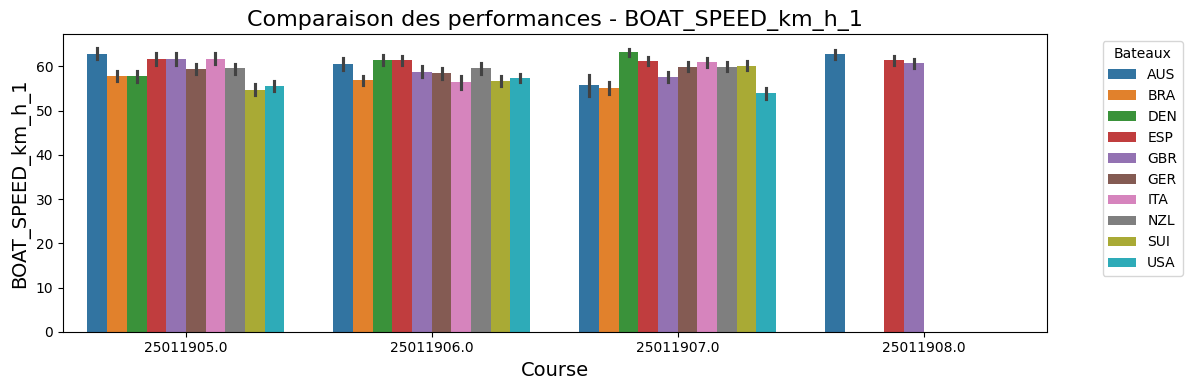

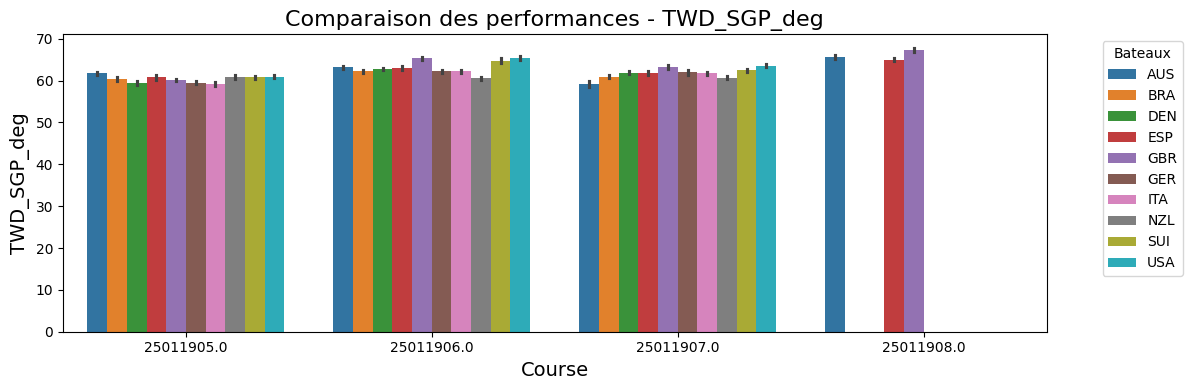

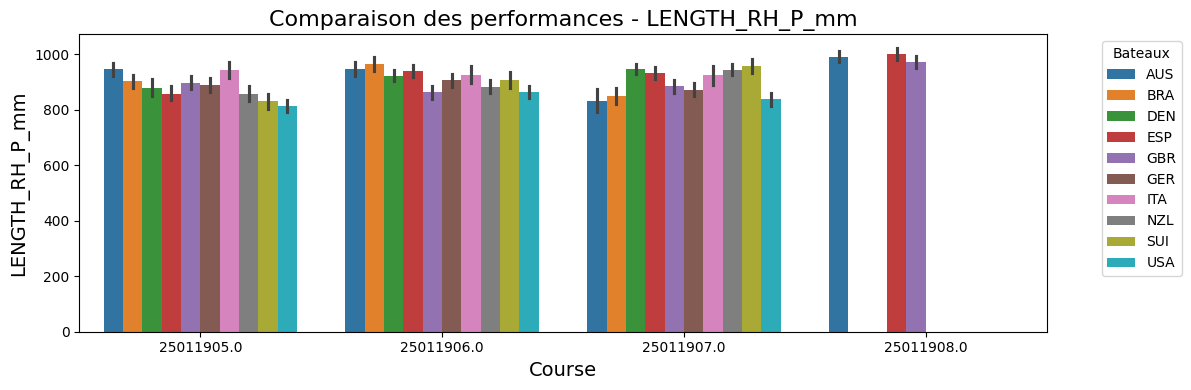

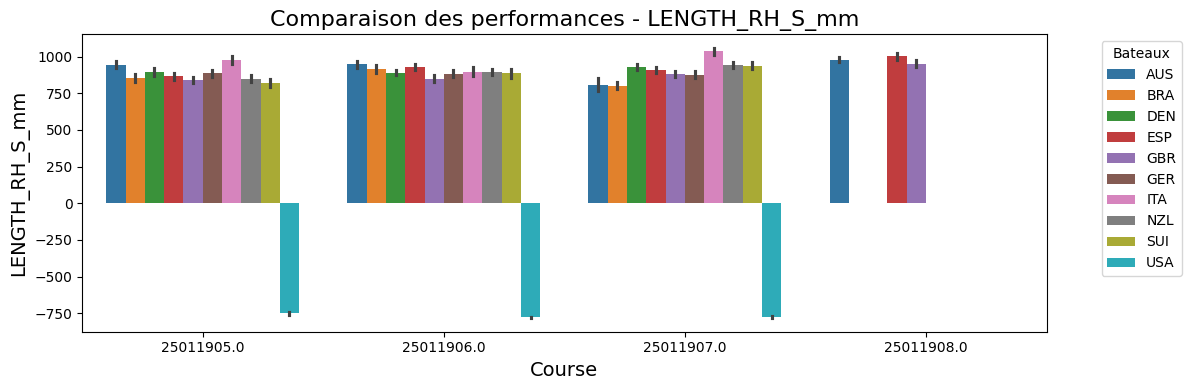

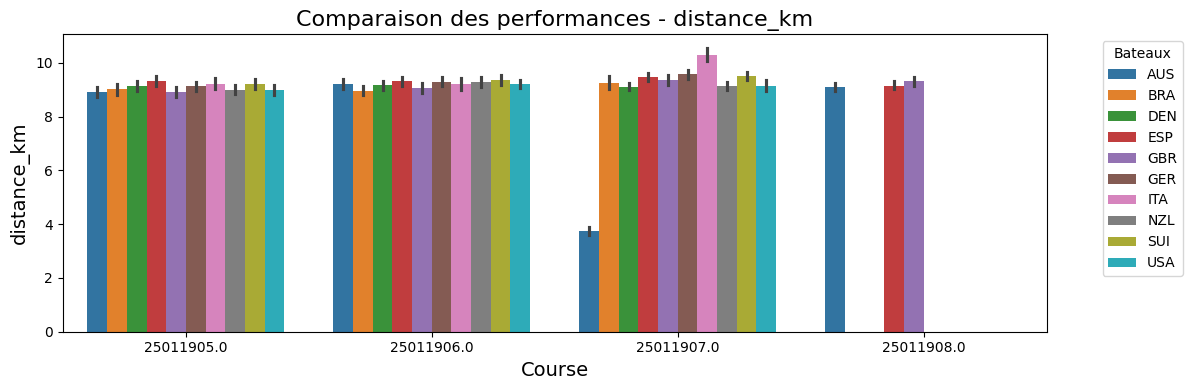

['25011905.0 (AUS)' '25011906.0 (AUS)' '25011907.0 (AUS)'
 '25011908.0 (AUS)' '25011905.0 (BRA)' '25011906.0 (BRA)'
 '25011907.0 (BRA)' '25011905.0 (DEN)' '25011906.0 (DEN)'
 '25011907.0 (DEN)' '25011905.0 (ESP)' '25011906.0 (ESP)'
 '25011907.0 (ESP)' '25011908.0 (ESP)' '25011905.0 (GBR)'
 '25011906.0 (GBR)' '25011907.0 (GBR)' '25011908.0 (GBR)'
 '25011905.0 (GER)' '25011906.0 (GER)' '25011907.0 (GER)'
 '25011905.0 (ITA)' '25011906.0 (ITA)' '25011907.0 (ITA)'
 '25011905.0 (NZL)' '25011906.0 (NZL)' '25011907.0 (NZL)'
 '25011905.0 (SUI)' '25011906.0 (SUI)' '25011907.0 (SUI)'
 '25011905.0 (USA)' '25011906.0 (USA)' '25011907.0 (USA)']


In [129]:
def analyze_races(data_dir='Data/Boat_logs'):
    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
    #print("CSV files:", csv_files)    
    combined_race_data = [] 

    for file_path in csv_files:
        data = pd.read_csv(file_path)
        race_ids = data['TRK_RACE_NUM_unk'].unique()

        for race_id in race_ids:
            race_data = data[
                (data['TRK_RACE_NUM_unk'] == race_id) & 
                (data['TRK_LEG_NUM_unk'] > 0) &
                (data['TRK_LEG_NUM_unk'] <= data['TRK_LEG_NUM_TOT_unk'])
            ].copy()
            #print("race_data", race_data.head())
            if race_data.empty:
                continue

            processed_data = []
            
            for boat_name, boat_data in race_data.groupby('BOAT'):
                boat_data = boat_data.reset_index(drop=True)
                boat_data['distance_km'] = 0.0
                #print("ini: ", boat_data['distance_km'])
                #print(boat_data)

                for i in range(1, len(boat_data)):                    
                    lat1, lon1 = boat_data.loc[i-1, ['LATITUDE_GPS_unk', 'LONGITUDE_GPS_unk']]
                    lat2, lon2 = boat_data.loc[i, ['LATITUDE_GPS_unk', 'LONGITUDE_GPS_unk']]
                    boat_data.at[i, 'distance_km'] = haversine_distance(lat1, lon1, lat2, lon2)
                    #boat_data.at[i, 'distance_km'] = round(distance, 2)
                race_distance = round(boat_data['distance_km'].sum(),2)
                #print(f"Bateau {boat_name} ({os.path.basename(file_path)}) - Course {race_id}: {race_distance:.2f} km")
                
                processed_data.append(boat_data)
            #boat_data.plot(x='LONGITUDE_GPS_unk', y='LATITUDE_GPS_unk', title = boat_name)
            # Combine les données de tous les bateaux pour cette course
            combined_data = pd.concat(processed_data)
            combined_race_data.append(combined_data)

    all_data = pd.concat(combined_race_data)

    all_data['Course_Boat'] = all_data['TRK_RACE_NUM_unk'].astype(str) + " (" + all_data['BOAT'] + ")"

    variables_to_analyze = [
        "BOAT_SPEED_km_h_1",
        "TWD_SGP_deg",
        "LENGTH_RH_P_mm",
        "LENGTH_RH_S_mm",
        "distance_km"
    ]

    for var in variables_to_analyze:
        plt.figure(figsize=(12, 4))
        if var == "distance_km":
            estimator_func = np.sum
        else:
            estimator_func = np.mean
            ylabel = var
            title_extra = ""
        sns.barplot(
            data=all_data,
            x='TRK_RACE_NUM_unk', 
            y=var,
            hue='BOAT',  
            estimator=estimator_func
        )
        plt.title(f"Comparaison des performances - {var}", fontsize=16)
        plt.xlabel("Course", fontsize=14)
        plt.ylabel(var, fontsize=14)
        plt.legend(title='Bateaux', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
        #print("all_data:", all_data)
    #all_data.to_csv('resultats_graph.csv', index=False)
    #print("Les données ont été sauvegardées dans 'resultats_graph.csv'")
    return all_data

all_data = analyze_races()
print(all_data['Course_Boat'].unique())


Aperçu du DataFrame modèle :
   TRK_RACE_NUM_unk BOAT        DATETIME_min        DATETIME_max  \
0        25011905.0  AUS 2025-01-19 03:08:01 2025-01-19 03:16:33   
1        25011905.0  BRA 2025-01-19 03:08:04 2025-01-19 03:17:26   
2        25011905.0  DEN 2025-01-19 03:08:03 2025-01-19 03:17:31   
3        25011905.0  ESP 2025-01-19 03:08:05 2025-01-19 03:17:09   
4        25011905.0  GBR 2025-01-19 03:08:03 2025-01-19 03:16:43   

   BOAT_SPEED_km_h_1_mean  TWS_SGP_km_h_1_mean  TWD_SGP_deg_mean  \
0               62.853902            38.556235         61.782863   
1               57.867211            38.279361         60.464210   
2               57.817083            40.435659         59.462566   
3               61.762404            39.455945         60.794147   
4               61.625950            40.573916         60.157351   

   PITCH_deg_mean  HEEL_deg_mean  RATE_YAW_deg_s_1_mean  distance_km_sum  \
0       -1.896686      -0.445902              -0.516118         8.921007   
1

c:\Users\Elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

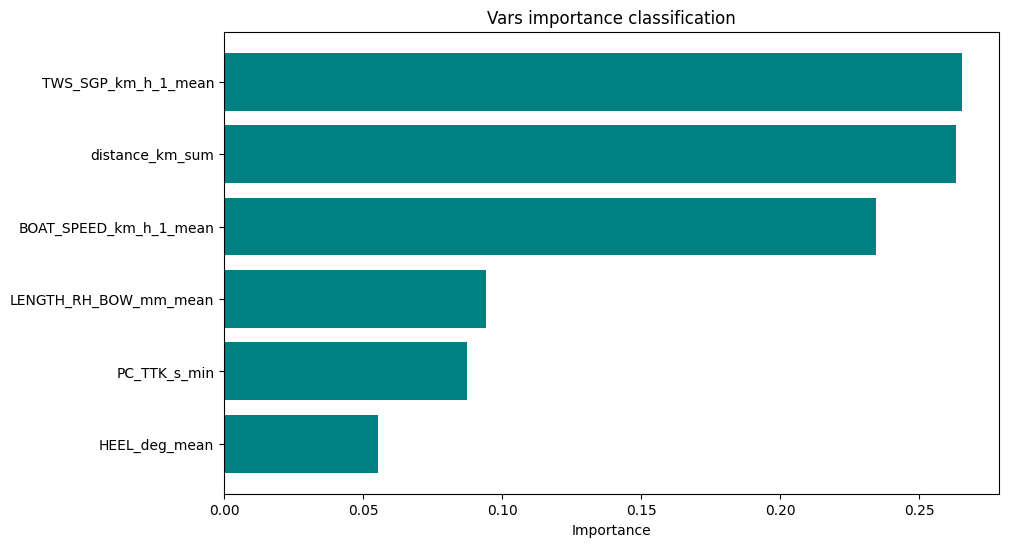

In [130]:
all_data['DATETIME'] = pd.to_datetime(all_data['DATETIME'])


agg_dict = {
    'DATETIME': [min, max],
    'BOAT_SPEED_km_h_1': 'mean',
    'TWS_SGP_km_h_1': 'mean',      
    'TWD_SGP_deg': 'mean',         
    'PITCH_deg': 'mean',            
    'HEEL_deg': 'mean',            
    'RATE_YAW_deg_s_1': 'mean',      
    'distance_km': sum,
    'LENGTH_RH_BOW_mm': 'mean',
    'PC_TTK_s' :'min' 
}

perf_summary = all_data.groupby(['TRK_RACE_NUM_unk', 'BOAT']).agg(agg_dict).reset_index()

perf_summary.columns = ['_'.join(col).strip('_') for col in perf_summary.columns.values]

# Race duration in seconds
perf_summary['race_duration'] = (perf_summary['DATETIME_max'] - perf_summary['DATETIME_min']).dt.total_seconds()
#print("race duration: ", perf_summary['race_duration'], "boat:", perf_summary['BOAT'])

# Get ranking
perf_summary['rank'] = perf_summary.groupby('TRK_RACE_NUM_unk')['DATETIME_max'] \
                                     .rank(method='min', ascending=True)

max_rank = perf_summary.groupby('TRK_RACE_NUM_unk')['rank'].transform('max')

perf_summary['is_winner'] = (perf_summary['rank'] == 1).astype(int)
perf_summary['is_last'] = (perf_summary['rank'] == max_rank).astype(int)

# Model df 
df_model = perf_summary.copy()

df_model['target'] = np.where(df_model['is_winner'] == 1, 1, 0)

print("Aperçu du DataFrame modèle :")
print(df_model.head())

# Vars selections 
"""features = [
    'BOAT_SPEED_km_h_1_mean',
    'TWS_SGP_km_h_1_mean',
    'TWD_SGP_deg_mean',
    'PITCH_deg_mean',
    'HEEL_deg_mean',
    'RATE_YAW_deg_s_1_mean',
    'distance_km_sum',
    'LENGTH_RH_BOW_mm_mean'
]"""

features = [
    'BOAT_SPEED_km_h_1_mean',
    'TWS_SGP_km_h_1_mean',
    'HEEL_deg_mean',
    'distance_km_sum',
    'LENGTH_RH_BOW_mm_mean',
    'PC_TTK_s_min'
]

X = df_model[features]
y = df_model['target']

# Train and test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#  Model training -
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prediction
y_pred = clf.predict(X_test)

# Model evaluation
print("\nModel performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Vars importance calculation
importances = clf.feature_importances_
feat_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\nVars importance :")
print(feat_importance_df)

# Importance visaulisation
plt.figure(figsize=(10,6))
plt.barh(feat_importance_df['feature'], feat_importance_df['importance'], color='teal')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Vars importance classification')
plt.show()


SailGP is not that different from other sailing races, at the end most of the time, the one who wins is the one with the best start, even if I did not manage yet to prove it with the data, the best combination of less traveled distance and best mean speed. 
On that race day, the AUS were ahead of the rest of the pack, with a mean TTK of -0.5s and a mean BS of 78.64kph on the first leg allowing them some space to do their strategy. 

While trying to look on why I have found that during those legs 1, the AUS seems to be a bit more radical on the wing trim:
ANGLE_WING_TWIST_deg = 0.253*BOAT_SPEED_km_h_1 + 7.11, the faster they are going the more twist they are putting on the wing and that is also due to their wing rot: ANGLE_WING_ROT_deg = -0.211*BOAT_SPEED_km_h_1 + 40.33 (obtained with the steamlit interface). And they are the only one to be that radical on their wing trim, the GBR are using a an almost opposite wing trim so it would be interesting to have some sailors insight on why.
